<a href="https://colab.research.google.com/github/jmParkGit/Colab/blob/main/Sparta_deepLearningWithImage/week5/week5_%EA%B7%B8%EB%A0%88%EC%9D%B4%EC%8A%A4%EC%BC%80%EC%9D%BC%EC%82%AC%EC%A7%84%EC%9D%84%EC%BB%AC%EB%9F%AC%EB%A1%9C%EB%B0%94%EA%BE%B8%EA%B3%A0%ED%95%B4%EC%83%81%EB%8F%84%ED%96%A5%EC%83%81%EC%8B%9C%ED%82%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 그레이스케일 사진을 컬러로 바꾸고, 해상도 4배 향샹 시키기


## open-cv-contrib-python 설치하기
- opencv-contrib-python은 opencv 4.2.0이상에서 사용가능하다.
- colab의 기본버전은 4.1.2이라서 지원하는 버전으로 설치해줘야한다.
- cv2 버전 체크 명령어
```python
import cv2
print(cv2.__version__)
````

In [1]:
!pip install opencv-contrib-python==4.3.0.36

     |████████████████████████████████| 49.9 MB 234 kB/s 
Reason for being yanked: Release deprecated
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## pkg 로드하기

In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## 그레이스케일을 컬러로 바꾸기위한, 모델 불러오기

In [3]:
proto = 'models/colorization_deploy_v2.prototxt'
weights = 'models/colorization_release_v2.caffemodel'

net = cv2.dnn.readNetFromCaffe(proto, weights)

pts_in_hull = np.load('models/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]

net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

## 해상도 4배 향샹을 위한 모델 불러오기

In [4]:
sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel('models/EDSR_x4.pb') #해상도 배율에따른 모델은 다름.
sr.setModel('edsr', 4) # 4배시 4, 3배시 3으로 바꿔줘야됨.

## 원본이미지 불러오기

input


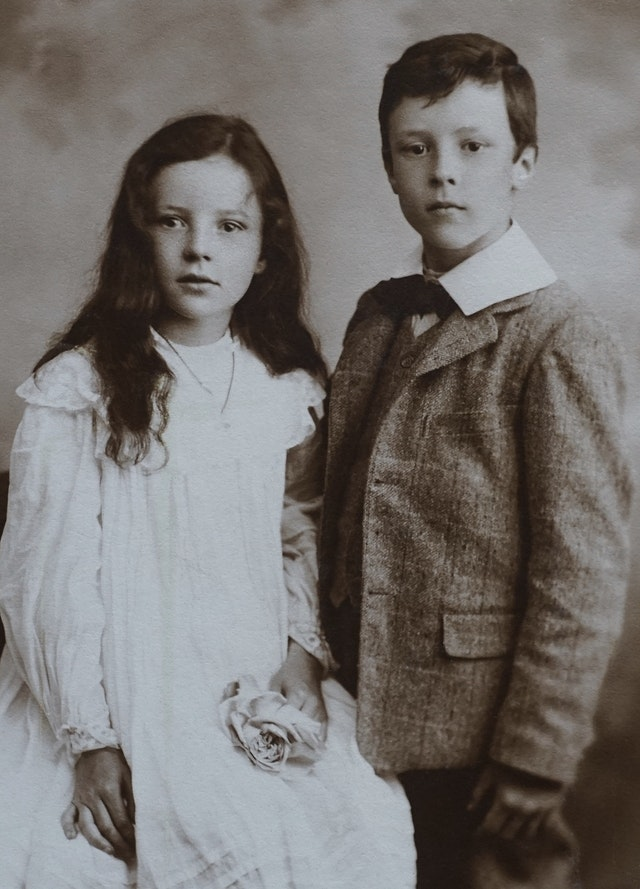

In [5]:
img = cv2.imread('imgs/07.jpg')

print('input')
cv2_imshow(img)

## cv2.resize()함수를 이용하여, 1/4 비율로 이미지 크기 줄여보기

resized_img) x1/4)::made by just resize()


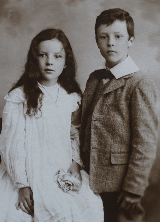

In [6]:
resized_img = cv2.resize(img, dsize=None, fx=1/4, fy=1/4)

print('resized_img) x1/4)::made by just resize()')
cv2_imshow(resized_img)

## 4배향샹 모델을 이용하여 이미지 해샹도 4배 확대하기

result::made by model x4


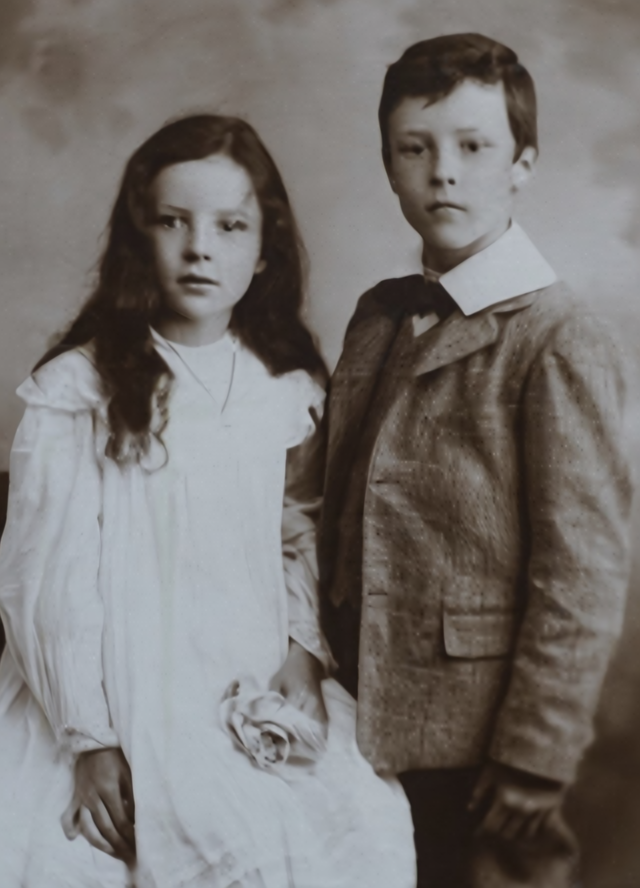

In [7]:
result = sr.upsample(resized_img)

print('result::made by model x4')
cv2_imshow(result)

## 이미지 컬러로 바꾸기위한, 전처리

In [8]:
h, w, c = result.shape

img_input = result.copy()

img_input = img_input.astype('float32') / 255.
img_lab = cv2.cvtColor(img_input, cv2.COLOR_BGR2Lab)
img_l = img_lab[:, :, 0:1]

## 그레이 스케일을 컬러로 바꾸기

colorized img


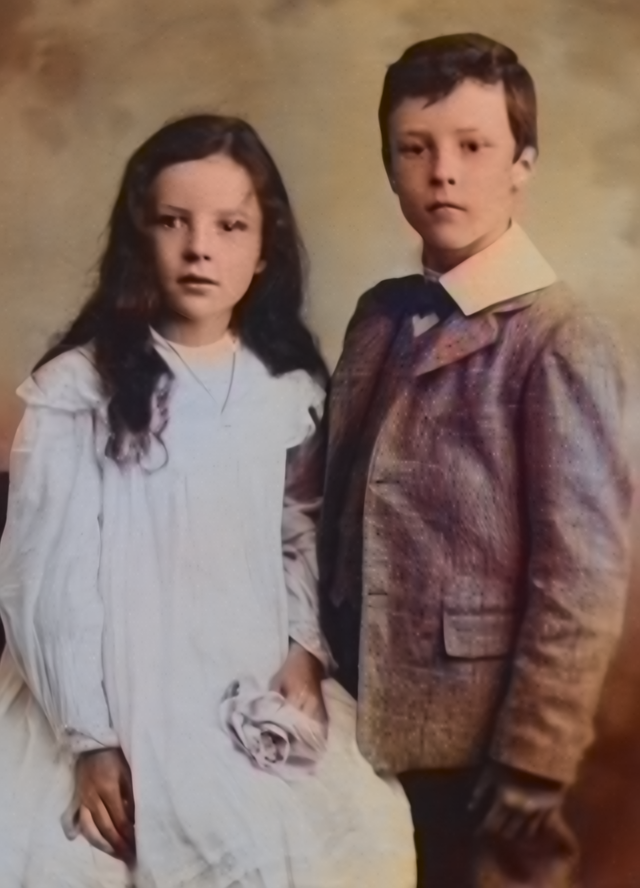

In [9]:
blob = cv2.dnn.blobFromImage(img_l, size=(224, 224), mean=[50, 50, 50])

net.setInput(blob)
output = net.forward()

output = output.squeeze().transpose((1,2,0))

output_resized=cv2.resize(output,(w,h))

output_lab = np.concatenate([img_l,output_resized], axis=2)

output_bgr = cv2.cvtColor(output_lab, cv2.COLOR_Lab2BGR)
output_bgr = output_bgr * 255
output_bgr = np.clip(output_bgr,0,255)
output_bgr = output_bgr.astype('uint8')

print('colorized img')
cv2_imshow(output_bgr)